In [1]:

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import os

from torchvision.io import read_image
import torch
import torchvision
from torchvision import transforms
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence



In [28]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, ssd300_vgg16, ssdlite320_mobilenet_v3_large
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
from dataset import BoarDataset
from boar_utils import show_image_with_boxes, nms
import os
import json
from boar_utils import get_current_time
INDEX = 2
CURRENT_TIME = "15-05-2024 16-06-00"
RESULTS_PATH = f"results/predictions/{CURRENT_TIME}/"
# os.mkdir(RESULTS_PATH)
MODEL_PATH = f"models/{CURRENT_TIME}/epoch_13_fasterrcnn_mobilenet_v3_large_fpn.pth"
THRESHOLD = 0.2
model = fasterrcnn_mobilenet_v3_large_fpn(num_classes=2, weights_backbone=torchvision.models.MobileNet_V3_Large_Weights.DEFAULT, trainable_backbone_layers=0)
model.load_state_dict(torch.load(MODEL_PATH))
TEST_IMG_PATH = "data/test/images"
TEST_ANNOTATION_PATH = "data/test/labels"
model.eval()
train_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])
test_dataset = BoarDataset(img_path=TEST_IMG_PATH, annotation_path=TEST_ANNOTATION_PATH,transform=train_transform, yolo_format=True)
test_dataset_vis = BoarDataset(img_path=TEST_IMG_PATH, annotation_path=TEST_ANNOTATION_PATH, yolo_format=True)
images = [test_dataset[INDEX]['image']]
boxes = model(images)
# boxes_score_zip = zip(boxes[0]['boxes'], boxes[0]['scores'])
# boxes = [box.tolist() for box, score in boxes_score_zip if score > THRESHOLD]
# show_image_with_boxes(test_dataset_vis[INDEX]['image'], boxes)#, save_path=RESULTS_PATH+f"{INDEX}.jpg")

In [29]:
supressed_boxes = nms(bboxes=boxes[0]['boxes'], confidence_scores=boxes[0]['scores'],confidence_threshold=0.1, iou_threshold=0.3)

In [30]:
supressed_boxes

{'boxes': tensor([]),
 'scores': tensor([]),
 'labels': tensor([], dtype=torch.int64)}

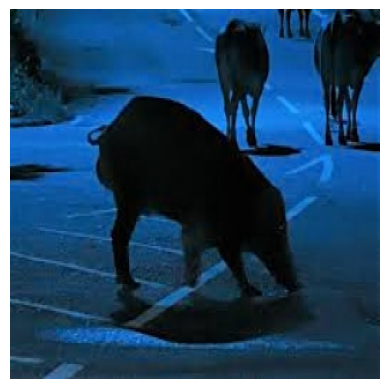

In [31]:
show_image_with_boxes(test_dataset_vis[INDEX]['image'], supressed_boxes['boxes'].tolist())#, save_path=RESULTS_PATH+f"{INDEX}.jpg")

In [35]:
from torchmetrics.detection import MeanAveragePrecision
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, ssd300_vgg16, ssdlite320_mobilenet_v3_large
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
from dataset import BoarDataset
from boar_utils import show_image_with_boxes, nms
import os
import json
from boar_utils import get_current_time
INDEX = 11
CURRENT_TIME = "15-05-2024 16-55-34"
# os.mkdir(RESULTS_PATH)
MODEL_PATH = f"models/{CURRENT_TIME}/epoch_11_fasterrcnn_mobilenet_v3_large_fpn.pth"
model = fasterrcnn_mobilenet_v3_large_fpn(num_classes=2, weights_backbone=torchvision.models.MobileNet_V3_Large_Weights.DEFAULT, trainable_backbone_layers=0)
model.load_state_dict(torch.load(MODEL_PATH))
TEST_IMG_PATH = "data/test/images"
TEST_ANNOTATION_PATH = "data/test/labels"
model.eval()
train_transform = transforms.Compose([
    transforms.ToTensor(), 
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  
    #                      std=[0.229, 0.224, 0.225])
])
test_dataset = BoarDataset(img_path=TEST_IMG_PATH, annotation_path=TEST_ANNOTATION_PATH,transform=train_transform, yolo_format=True)
map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox')

# Iterate over the dataset and calculate predictions
for i in range(len(test_dataset)):
    print(i)
    images = [test_dataset[i]['image']]
    targets = test_dataset[i]['target']

    with torch.no_grad():
        predictions = model(images)
    boxes = model(images)
    supressed_boxes = nms(bboxes=boxes[0]['boxes'], confidence_scores=boxes[0]['scores'],confidence_threshold=0, iou_threshold=0.3)
    # Update the metric with current batch
    map_metric.update([supressed_boxes], [targets])

# Compute the final mAP score
map_result = map_metric.compute()
print(map_result)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
